In [1]:
import numpy as np
import matplotlib
import sys
import os

sys.path.append('../qslam/')
from visualiserisk import *

In [2]:
#################################
# Defaults
#################################

numofnodes=25
repts = 50
likelihoodparams_scan = np.load('random_variances.npz')
lambda_pairs = np.load('lambda_pairs_2.npz')
particleconfigs = [ [3,2], [9,6], [15,10] , [21,14], [30, 20]]
max_iterations = 75

path = './data_v3/'
datatype=['Uni_R', 'Trunc_R']
keys =  ['marginalised_weights', 'predictive_weights', 'alpha_labels', 'beta_labels', 'rate_of_change_of_len', 'joint_labels', 'posterior_weights', 'joint_weights', 'leaf_weights']

In [3]:
#################################
# ZERO LAMBDA (NOT OPTIMAL) CASE
################################## 
idx_1 = 16
idx_2 = 0
idx_prefix=1 
prefix = '_idx_prefix_'+str(idx_prefix)+'_'


#################################
# Base Case from Short Paper
#################################

bse_typ = 0
bse_1 = 0 # for idx_1 in [3,4,5,6]:#,7,0,1,2]:
bse_2 = 1 # for idx_2 in [3,4,5,6]:#,7,0,1,2]:
bse_3 = 2 # for idx_3 in range(len(particleconfigs)):

base_data = np.load('./data/'+datatype[bse_typ]+prefix+str(bse_1)+'_'+str(bse_2)+'_'+str(bse_3)+'.npz')
baseline_err = np.sum(np.mean(base_data['absolute_errors_matrix'], axis=0), axis=1)

base_case_scaling_matr = 100*np.ones((len(particleconfigs), max_iterations))

for idx_pconfig in range(len(particleconfigs)):

    base_data_scaling = np.load('./data/'+datatype[bse_typ]+prefix+str(bse_1)+'_'+str(bse_2)+'_'+str(idx_pconfig)+'.npz')
    base_case_scaling_matr[idx_pconfig, :] = np.sum(np.mean(base_data_scaling['absolute_errors_matrix']**2, axis=0), axis=1)


### Fig 1

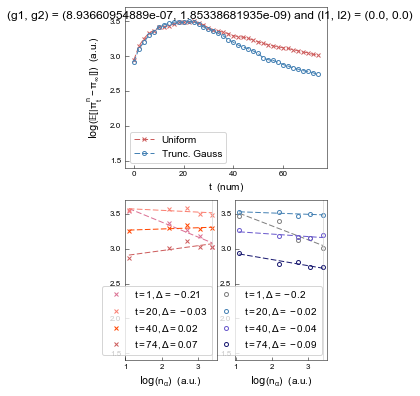

In [4]:
#################################
# DATA ANALYSIS
#################################

error_scaling_matrix_0 = 100.*np.ones((len(particleconfigs), max_iterations))
error_scaling_matrix_1 = 100.*np.ones((len(particleconfigs), max_iterations))

    
for idx_pconfig in range(len(particleconfigs)):
    
    test_data_0 = np.load(path+datatype[0]+prefix+'rand_'+str(idx_1)+'_'+str(idx_2)+'_'+str(idx_pconfig)+'.npz')
    error_scaling_matrix_0[idx_pconfig, :] = np.sum(np.mean(test_data_0['absolute_errors_matrix']**2, axis=0), axis=1)

    test_data_1 = np.load(path+datatype[1]+prefix+'rand_'+str(idx_1)+'_'+str(idx_2)+'_'+str(idx_pconfig)+'.npz')
    error_scaling_matrix_1[idx_pconfig, :] = np.sum(np.mean(test_data_1['absolute_errors_matrix']**2, axis=0), axis=1)

particle_number = np.asarray([idp[0] for idp in particleconfigs] ) 
idx_pconfig_T = np.argmin(error_scaling_matrix_1[:,74])

#################################
# FIGURE
#################################

colorsU = [ 'indianred', 'orangered', 'salmon', 'palevioletred' ]#, 'pink']
colors = ['midnightblue', 'slateblue',   'steelblue', 'gray']#'lightsteelblue']
colors=colors[::-1]
colorsU=colorsU[::-1]
times =[1, 20, 40 ,74]

gslayout = gs(2,2, top = 0.99, bottom =0.1, left = 0.15, right = 0.98, wspace = 0.2, hspace = 0.2)

fig = plt.figure(figsize=(cm2inch(8.6),cm2inch(14)))

    
plt.suptitle('(g1, g2) = (%s, %s) and (l1, l2) = (%s, %s)' %(likelihoodparams_scan['g1var'][idx_1], 
                                                             likelihoodparams_scan['g2var'][idx_1],
                                                             lambda_pairs['lambda_1'][idx_2],
                                                             lambda_pairs['lambda_2'][idx_2],
                                                             
                                                            ),
            )

ax_err = fig.add_subplot(gslayout[0, :])
ax_scl = fig.add_subplot(gslayout[1, 1])
ax_uni = fig.add_subplot(gslayout[1, 0])

#################################
# bottom
#################################
for idx_t in range(len(times)):

    slope, intercept = np.polyfit(np.log(particle_number), np.log(error_scaling_matrix_1[:, times[idx_t]]), 1)

    ax_scl.plot(np.log(particle_number), np.log( error_scaling_matrix_1[:, times[idx_t]]), 
             'o', ms=4, markerfacecolor='None', lw=1., c= colors[idx_t], label= r'$t=%s, \Delta = %s$'%(times[idx_t], np.round(slope, 2)))
    
    trendpoly = np.poly1d([slope,intercept]) 
    
    ax_scl.plot(np.log(particle_number),trendpoly(np.log(particle_number)), '--',  lw=1., c= colors[idx_t])
    ax_scl.axvline(x=np.log(particleconfigs[idx_pconfig_T][0]), ls='-', lw=0.5, c='lightgray', alpha=0.5)
    
ax_scl.set_xlabel(r'$\log(n_\alpha)$  (a.u.)')
ax_scl.set_ylabel(r'$\log(\mathbb{E}[|\pi^n_t - \pi_\infty|])$  (a.u.)')
ax_scl.set_ylim([1.4, 3.7])
ax_scl.legend(loc=0)



for idx_t in range(len(times)):

    slope, intercept = np.polyfit(np.log(particle_number), np.log(error_scaling_matrix_0[:, times[idx_t]]), 1)

    ax_uni.plot(np.log(particle_number), np.log( error_scaling_matrix_0[:, times[idx_t]]), 
             'x', lw=1., ms=4, c= colorsU[idx_t], label= r'$t=%s, \Delta = %s$'%(times[idx_t], np.round(slope, 2)))
    
    trendpoly = np.poly1d([slope,intercept]) 
    
    ax_uni.plot(np.log(particle_number),trendpoly(np.log(particle_number)), '--', lw=1.,  c= colorsU[idx_t])
    ax_uni.axvline(x=np.log(particleconfigs[idx_pconfig_T][0]), ls='-', lw=0.5, c='lightgray', alpha=0.5)
    
ax_uni.set_xlabel(r'$\log(n_\alpha)$  (a.u.)')
#ax_uni.set_ylabel(r'$\log(\mathbb{E}[|\pi^n_t - \pi_\infty|])$  (a.u.)')
ax_uni.set_ylim([1.4, 3.7])
ax_uni.legend(loc=0)

#################################
# top
#################################

#ax_err.fill_between(range(75), np.log(base_case_scaling_matr[bse_3, :]), alpha=0.1, color='gray', label='Prev. Reported (baseline)')
#ax_err.plot(range(75),np.log(base_case_scaling_matr[bse_3, :]), '-',  lw=1., c='k', label='Baseline')
ax_err.plot(range(75)[::2],np.log(error_scaling_matrix_0[idx_pconfig_T, ::2]), 'x--', 
            lw=1., ms=4, c='indianred', 
            label='Uniform')



ax_err.plot(range(75)[::2],np.log(error_scaling_matrix_1[idx_pconfig_T, ::2]), 'o--', 
            lw=1., ms=4, 
            c='steelblue',
            markerfacecolor='None', label='Trunc. Gauss', alpha=1.)

ax_err.set_xlabel(r'$t$  (num)')
ax_err.set_ylabel(r'$\log(\mathbb{E}[|\pi^n_t - \pi_\infty|])$  (a.u.)')
ax_err.set_ylim([1.4, 3.7])
ax_err.legend(loc=0)

plt.savefig('fig_zerolambda_error_'+str(idx_prefix)+'.svg', format='svg', dpi=800)
plt.show()

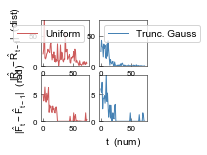

In [10]:
test_data_0 = np.load(path+datatype[0]+prefix+'rand_'+str(idx_1)+'_'+str(idx_2)+'_'+str(idx_pconfig_T)+'.npz')
test_data_1 = np.load(path+datatype[1]+prefix+'rand_'+str(idx_1)+'_'+str(idx_2)+'_'+str(idx_pconfig_T)+'.npz')

rate_of_change_of_map_0 = test_data_0['rate_of_change_of_map'][np.random.randint(low=0, high=50)]
rate_of_change_of_len_0 = test_data_0['rate_of_change_of_len'][np.random.randint(low=0, high=50)]
rate_of_change_of_map_1 = test_data_1['rate_of_change_of_map'][np.random.randint(low=0, high=50)]
rate_of_change_of_len_1 = test_data_1['rate_of_change_of_len'][np.random.randint(low=0, high=50)]

fig = plt.figure(figsize=(cm2inch(4.5),cm2inch(4)))
gslayout = gs(2,2, top = 0.99, bottom =0.1, left = 0.15, right = 0.98, wspace = 0.2, hspace = 0.2)

ax3 = fig.add_subplot(gslayout[1, 0])
ax3.set_ylabel(r"$ | \hat{F}_t - \hat{F}_{t-1}|$  (rad)")
ax3.plot(np.sum(rate_of_change_of_map_0, axis=1)[1:], c='indianred',lw=1)
ax3.set_ylim([0., 8.5])


ax1 = fig.add_subplot(gslayout[0, 0])
ax1.set_ylabel(r"$ | \hat{R}_t - \hat{R}_{t-1}|$  (dist)")
ax1.plot(np.sum(rate_of_change_of_len_0, axis=1)[1:], c='indianred', lw=1, label='Uniform')
ax1.set_ylim([0.00, 75])
ax1.legend(loc=0)
#plt.yscale('log')


ax4 = fig.add_subplot(gslayout[1,1])
ax4.plot(np.sum(rate_of_change_of_map_1, axis=1)[1:], c='steelblue', lw=1)
ax4.set_ylim([0., 8.5])
ax4.set_xlabel(r'$t$  (num)')

ax2 = fig.add_subplot(gslayout[0,1])
ax2.plot(np.sum(rate_of_change_of_len_1, axis=1)[1:], c='steelblue', lw=1, label='Trunc. Gauss')
ax2.set_ylim([0.0, 75])
ax2.legend(loc=0)

plt.savefig('fig_zerolambda_error_state_change_'+str(idx_prefix)+'.svg', format='svg', dpi=800)
plt.show()